# Test of custom layers

In [1]:
import sys
sys.path.append('..')
import numpy as np
from functools import reduce
from operator import mul
import tensorflow as tf
tf.enable_eager_execution() 
m = tf.compat.v2.math
keras = tf.compat.v2.keras
K = keras.backend

In [38]:
# test setup
def test_layer(make_layer):
    VALUE_SHAPE = (3,)
    
    in_vals = [
        np.array([
            np.reshape(np.arange(0,reduce(mul, VALUE_SHAPE), dtype=np.dtype('float32')), VALUE_SHAPE)-10,
            np.reshape(np.arange(0,reduce(mul, VALUE_SHAPE), dtype=np.dtype('float32')), VALUE_SHAPE),
        ]),
        np.array([
            np.ones(VALUE_SHAPE, dtype=np.dtype('float32')),
            np.zeros(VALUE_SHAPE, dtype=np.dtype('float32'))
        ])
    ]
    
    out_val = make_layer()(in_vals)
    return out_val

In [39]:
# CCSA-keras implementation

def euclidean_distance(vects):
    eps = 1e-08
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), eps))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def make_euc_dist():
    return keras.layers.Lambda(
        euclidean_distance, 
        output_shape=eucl_dist_output_shape, name='CSA'
    )

test_layer(make_euc_dist).numpy()

array([[17.378147],
       [ 2.236068]], dtype=float32)

In [45]:
# custom distance layer implementation
M = tf.compat.v2.math
class Distance(keras.layers.Layer):
    '''
    Frobenius Norm of distance between inputs.
    Assumes the input two be array-like with two elements
    Implementation only supports 1D data
    '''
    def __init__(self, name=None):
        super(Distance, self).__init__(name=name)

    def call(self, inputs):
        a = inputs[0]
        b = inputs[1]
        return M.square(M.sqrt(M.reduce_sum(M.square(a-b),axis=1)))

M.sqrt(test_layer(Distance).numpy()).numpy()

array([17.378147,  2.236068], dtype=float32)

In [23]:
ld = [
    {'a':1, 'b':10},
    {'a':2, 'b':20},
]

In [27]:
reduce(lambda dn, do: {k:dn[k]+do[k] for k in dn},ld, {k:0 for k in ld[0]})

{'a': 3, 'b': 30}

In [28]:
ll = [
    [1,10],
    [2,20]
]

In [30]:
reduce(
    lambda n, o: [n[i]+o[i] for i in range(len(ll))],
    ll, 
    [0 for _ in ll[0]]
)

[3, 30]

In [101]:
bs = 2 #batch size
es = 3 # embed size
xs = tf.constant([[1,2,3],[4,5,6]], dtype=tf.float32)
xt = tf.constant([[3,2,1],[4,4,4]], dtype=tf.float32)

In [109]:
xs_rpt = tf.broadcast_to(tf.expand_dims(xs, axis=0),shape=(bs,bs,es),name=None)
xt_rpt = tf.broadcast_to(tf.expand_dims(xt, axis=1),shape=(bs,bs,es),name=None)

In [137]:
dists = tf.reduce_sum(tf.square(xs_rpt-xt_rpt), axis=2)
dists

<tf.Tensor: id=420, shape=(2, 2), dtype=float32, numpy=
array([[ 8., 35.],
       [14.,  5.]], dtype=float32)>

In [150]:
ys = tf.constant([0,1])
yt = tf.constant([1,2])

In [151]:
ys_rpt = tf.broadcast_to(tf.expand_dims(ys, axis=1), shape=(bs, bs))
yt_rpt = tf.broadcast_to(tf.expand_dims(yt, axis=0), shape=(bs, bs))

In [152]:
y_same = tf.cast(tf.equal(ys_rpt,yt_rpt), tf.float32)
y_diff = tf.cast(tf.not_equal(ys_rpt,yt_rpt), tf.float32)
y_same, y_diff

(<tf.Tensor: id=468, shape=(2, 2), dtype=float32, numpy=
 array([[0., 0.],
        [1., 0.]], dtype=float32)>,
 <tf.Tensor: id=470, shape=(2, 2), dtype=float32, numpy=
 array([[1., 1.],
        [0., 1.]], dtype=float32)>)

In [153]:
intra_cls_dists = tf.multiply(sum_square, y_same)
inter_cls_dists = tf.multiply(sum_square, y_diff)
intra_cls_dists, inter_cls_dists

(<tf.Tensor: id=473, shape=(2, 2), dtype=float32, numpy=
 array([[ 0.,  0.],
        [14.,  0.]], dtype=float32)>,
 <tf.Tensor: id=474, shape=(2, 2), dtype=float32, numpy=
 array([[ 8., 35.],
        [ 0.,  5.]], dtype=float32)>)

In [154]:
max_dists = tf.reduce_max(dists, axis=1, keepdims=True)
max_dists = tf.broadcast_to(max_dists, shape=(bs, bs))
max_dists

<tf.Tensor: id=480, shape=(2, 2), dtype=float32, numpy=
array([[35., 35.],
       [14., 14.]], dtype=float32)>

In [155]:
y_same, max_dists, inter_cls_dists

(<tf.Tensor: id=468, shape=(2, 2), dtype=float32, numpy=
 array([[0., 0.],
        [1., 0.]], dtype=float32)>,
 <tf.Tensor: id=480, shape=(2, 2), dtype=float32, numpy=
 array([[35., 35.],
        [14., 14.]], dtype=float32)>,
 <tf.Tensor: id=474, shape=(2, 2), dtype=float32, numpy=
 array([[ 8., 35.],
        [ 0.,  5.]], dtype=float32)>)

In [158]:
revised_inter_cls_dists = tf.where(tf.cast(y_same, dtype=tf.bool), max_dists, inter_cls_dists)
revised_inter_cls_dists

<tf.Tensor: id=491, shape=(2, 2), dtype=float32, numpy=
array([[ 8., 35.],
       [14.,  5.]], dtype=float32)>

In [159]:
max_intra_cls_dist = tf.reduce_max(intra_cls_dists, axis=1)
min_inter_cls_dist = tf.reduce_min(revised_inter_cls_dists, axis=1)
max_intra_cls_dist, min_inter_cls_dist

(<tf.Tensor: id=494, shape=(2,), dtype=float32, numpy=array([ 0., 14.], dtype=float32)>,
 <tf.Tensor: id=496, shape=(2,), dtype=float32, numpy=array([8., 5.], dtype=float32)>)

In [165]:
margin=0
tf.nn.relu(max_intra_cls_dist - min_inter_cls_dist + margin)

<tf.Tensor: id=518, shape=(2,), dtype=float32, numpy=array([0., 9.], dtype=float32)>

In [166]:
def ho(a):
    def fn(b):
        return a+b
    return fn

ho(2)(3)

5

In [172]:
ys=tf.constant([1,2,1])
yt=tf.constant([1,2,2])

In [176]:
tf.cast(tf.equal(ys,yt), dtype=tf.float32)

<tf.Tensor: id=528, shape=(3,), dtype=float32, numpy=array([1., 1., 0.], dtype=float32)>

In [177]:
ys

<tf.Tensor: id=520, shape=(3,), dtype=int32, numpy=array([1, 2, 1], dtype=int32)>

In [183]:
ys.shape[0]

Dimension(3)

In [184]:
tf.compat.v2.TensorShape([2,ys.shape[0]])

TensorShape([Dimension(2), Dimension(3)])

In [208]:
y_true = tf.constant([[[1,0,0],[0,1,0]], [[1,0,0],[0,0,1]]])
y_true

<tf.Tensor: id=638, shape=(2, 2, 3), dtype=int32, numpy=
array([[[1, 0, 0],
        [0, 1, 0]],

       [[1, 0, 0],
        [0, 0, 1]]], dtype=int32)>

In [219]:
ys, yt = y_true
ys, yt

(<tf.Tensor: id=683, shape=(2, 3), dtype=int32, numpy=
 array([[1, 0, 0],
        [0, 1, 0]], dtype=int32)>,
 <tf.Tensor: id=687, shape=(2, 3), dtype=int32, numpy=
 array([[1, 0, 0],
        [0, 0, 1]], dtype=int32)>)

In [228]:
tf.cast(tf.reduce_all(tf.equal(ys,yt),axis=1, keepdims=True), dtype=tf.float32)

<tf.Tensor: id=733, shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [0.]], dtype=float32)>

In [216]:
ys-yt

<tf.Tensor: id=673, shape=(2, 3), dtype=int32, numpy=
array([[ 0,  0,  0],
       [ 0,  1, -1]], dtype=int32)>

In [231]:
K.square(ys)

<tf.Tensor: id=738, shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 1, 0]], dtype=int32)>

# Graph Embedding

In [107]:
xs = tf.constant([[1,2,3],[4,5,6]], dtype=tf.float32)
xt = tf.constant([[3,2,1],[4,4,4]], dtype=tf.float32)
ys = tf.constant([0,1])
yt = tf.constant([0,1])

In [63]:
y_true = tf.constant([[[True, False, False], [True, False, False]],
                      [[False, False, True], [False, False, True]]])

y_pred = tf.constant([[[1,2,3],[4,5,6]],
                      [[3,2,1],[4,4,4]]], dtype=tf.float32)

In [64]:
ys = tf.argmax(tf.cast(y_true[:,0], dtype=tf.int32), axis=1)
yt = tf.argmax(tf.cast(y_true[:,1], dtype=tf.int32), axis=1)
xs = y_pred[:,0]
xt = y_pred[:,1]
θϕ = tf.transpose(tf.concat([xs,xt], axis=0))
ys, yt, xs, xt, θϕ

(<tf.Tensor: id=1665, shape=(2,), dtype=int64, numpy=array([0, 2])>,
 <tf.Tensor: id=1672, shape=(2,), dtype=int64, numpy=array([0, 2])>,
 <tf.Tensor: id=1676, shape=(2, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [3., 2., 1.]], dtype=float32)>,
 <tf.Tensor: id=1680, shape=(2, 3), dtype=float32, numpy=
 array([[4., 5., 6.],
        [4., 4., 4.]], dtype=float32)>,
 <tf.Tensor: id=1684, shape=(3, 4), dtype=float32, numpy=
 array([[1., 3., 4., 4.],
        [2., 2., 5., 4.],
        [3., 1., 6., 4.]], dtype=float32)>)

In [65]:
batch_size = ys.shape[0].value
batch_size

2

In [68]:
# make_weights: relate_all
N = 2*batch_size 
y = tf.concat([ys, yt], axis = 0) # TODO: verify axis
yTe = tf.broadcast_to(tf.expand_dims(y, axis=1), shape=(N, N))
eTy = tf.broadcast_to(tf.expand_dims(y, axis=0), shape=(N, N))

W = tf.equal(yTe, eTy)
Wp = tf.not_equal(yTe, eTy)
N, y, yTe, eTy, W, Wp

(4,
 <tf.Tensor: id=1731, shape=(4,), dtype=int64, numpy=array([0, 2, 0, 2])>,
 <tf.Tensor: id=1735, shape=(4, 4), dtype=int64, numpy=
 array([[0, 0, 0, 0],
        [2, 2, 2, 2],
        [0, 0, 0, 0],
        [2, 2, 2, 2]])>,
 <tf.Tensor: id=1739, shape=(4, 4), dtype=int64, numpy=
 array([[0, 2, 0, 2],
        [0, 2, 0, 2],
        [0, 2, 0, 2],
        [0, 2, 0, 2]])>,
 <tf.Tensor: id=1740, shape=(4, 4), dtype=bool, numpy=
 array([[ True, False,  True, False],
        [False,  True, False,  True],
        [ True, False,  True, False],
        [False,  True, False,  True]])>,
 <tf.Tensor: id=1741, shape=(4, 4), dtype=bool, numpy=
 array([[False,  True, False,  True],
        [ True, False,  True, False],
        [False,  True, False,  True],
        [ True, False,  True, False]])>)

In [67]:
# make weights: relate source-target
N = 2*batch_size 
tile_size = [batch_size, batch_size]
i = tf.concat([ tf.concat([tf.zeros(tile_size, dtype=tf.bool), tf.ones(tile_size, dtype=tf.bool)], axis=0),
                tf.concat([tf.ones(tile_size, dtype=tf.bool), tf.zeros(tile_size, dtype=tf.bool)], axis=0) ], axis=1 )
zeros = tf.zeros([N,N],dtype=tf.bool)
W = tf.where(i, W, zeros)
Wp = tf.where(i, Wp, zeros)
W, Wp

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor: id=1728, shape=(4, 4), dtype=bool, numpy=
 array([[False, False,  True, False],
        [False, False, False,  True],
        [ True, False, False, False],
        [False,  True, False, False]])>,
 <tf.Tensor: id=1729, shape=(4, 4), dtype=bool, numpy=
 array([[False, False, False,  True],
        [False, False,  True, False],
        [False,  True, False, False],
        [ True, False, False, False]])>)

In [154]:
# make weights: relate source-target pair
eq = tf.linalg.diag(tf.equal(ys, yt))
neq = tf.linalg.diag(tf.not_equal(ys, yt))
zeros = tf.zeros([batch_size, batch_size],dtype=tf.bool)
W = tf.concat([tf.concat([zeros, eq],axis=0),
               tf.concat([eq, zeros],axis=0)], axis=1)
Wp = tf.concat([tf.concat([zeros, neq],axis=0),
                tf.concat([neq, zeros],axis=0)], axis=1)
eq, neq, W, Wp

(<tf.Tensor: id=1080, shape=(2, 2), dtype=bool, numpy=
 array([[ True, False],
        [False,  True]])>,
 <tf.Tensor: id=1082, shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: id=1093, shape=(4, 4), dtype=bool, numpy=
 array([[False, False,  True, False],
        [False, False, False,  True],
        [ True, False, False, False],
        [False,  True, False, False]])>,
 <tf.Tensor: id=1099, shape=(4, 4), dtype=bool, numpy=
 array([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])>)

In [155]:
W, Wp = tf.cast(W, dtype=tf.float32), tf.cast(Wp, dtype=tf.float32)

In [156]:
D  = tf.linalg.diag(tf.reduce_sum(W,  axis=1)) 
Dp = tf.linalg.diag(tf.reduce_sum(Wp, axis=1))
D, Dp

(<tf.Tensor: id=1104, shape=(4, 4), dtype=float32, numpy=
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=float32)>,
 <tf.Tensor: id=1107, shape=(4, 4), dtype=float32, numpy=
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32)>)

In [157]:
L  = tf.subtract(D, W)
Lp = tf.subtract(Dp, Wp)
L, Lp

(<tf.Tensor: id=1108, shape=(4, 4), dtype=float32, numpy=
 array([[ 1.,  0., -1.,  0.],
        [ 0.,  1.,  0., -1.],
        [-1.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  1.]], dtype=float32)>,
 <tf.Tensor: id=1109, shape=(4, 4), dtype=float32, numpy=
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32)>)

In [145]:
θϕLϕθ  = tf.matmul(θϕ, tf.matmul(L,  θϕ, transpose_b=True))
θϕLpϕθ = tf.matmul(θϕ, tf.matmul(Lp, θϕ, transpose_b=True))
θϕLϕθ, θϕLpϕθ

(<tf.Tensor: id=988, shape=(3, 3), dtype=float32, numpy=
 array([[10., 11., 12.],
        [11., 13., 15.],
        [12., 15., 18.]], dtype=float32)>,
 <tf.Tensor: id=990, shape=(3, 3), dtype=float32, numpy=
 array([[10.,  9.,  8.],
        [ 9., 13., 17.],
        [ 8., 17., 26.]], dtype=float32)>)

In [146]:
loss = tf.linalg.trace(θϕLϕθ) / tf.linalg.trace(θϕLpϕθ)
loss

<tf.Tensor: id=997, shape=(), dtype=float32, numpy=0.8367347>

# Test implementation

In [2]:
from losses.dage import dist2indicator, dist2gaussian, relate_all, relate_source_target, make_filter, FilterType 

xs = tf.constant([[1,2,3],[4,5,6],[3,3,1]], dtype=tf.float32)
xt = tf.constant([[3,2,1],[4,4,4],[4,4,1]], dtype=tf.float32)
ys = tf.constant([0,0,0])
yt = tf.constant([0,0,0])
batch_size = 3

W, Wp = relate_all(ys,yt,batch_size)
# W_Wp = relate_source_target(ys,yt,batch_size)

filt = make_filter(
    filter_type=FilterType.ALL, #ALL, KNN, KFN, EPSILON,
    penalty_filter_type=FilterType.ALL, 
    filter_param=1, 
    penalty_filter_param=1
)
W_filt, Wp_filt = filt((W, Wp), xs, xt)

W, W_filt

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor: id=14, shape=(6, 6), dtype=bool, numpy=
 array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]])>,
 <tf.Tensor: id=46, shape=(6, 6), dtype=float32, numpy=
 array([[ 0., 27.,  9.,  8., 14., 17.],
        [27.,  0., 30., 35.,  5., 26.],
        [ 9., 30.,  0.,  1., 11.,  2.],
        [ 8., 35.,  1.,  0., 14.,  5.],
        [14.,  5., 11., 14.,  0.,  9.],
        [17., 26.,  2.,  5.,  9.,  0.]], dtype=float32)>)

In [3]:
filt = make_filter(
    filter_type=FilterType.KNN, #ALL, KNN, KFN, EPSILON,
    penalty_filter_type=FilterType.KNN, 
    filter_param=2, 
    penalty_filter_param=1
)
W_filt, Wp_filt = filt((W, Wp), xs, xt)

W_filt

<tf.Tensor: id=140, shape=(6, 6), dtype=float32, numpy=
array([[ 0., 27.,  0.,  0.,  0., 17.],
       [ 0.,  0., 30., 35.,  0.,  0.],
       [ 0., 30.,  0.,  0., 11.,  0.],
       [ 0., 35.,  0.,  0., 14.,  0.],
       [14.,  0.,  0., 14.,  0.,  0.],
       [17., 26.,  0.,  0.,  0.,  0.]], dtype=float32)>

In [4]:
filt = make_filter(
    filter_type=FilterType.KFN, #ALL, KNN, KFN, EPSILON,
    penalty_filter_type=FilterType.KNN, 
    filter_param=2, 
    penalty_filter_param=1
)
W_filt, Wp_filt = filt((W, Wp), xs, xt)

W_filt

<tf.Tensor: id=303, shape=(6, 6), dtype=float32, numpy=
array([[ 0.,  0.,  9.,  8.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5., 26.],
       [ 0.,  0.,  0.,  1.,  0.,  2.],
       [ 0.,  0.,  1.,  0.,  0.,  5.],
       [ 0.,  5.,  0.,  0.,  0.,  9.],
       [ 0.,  0.,  2.,  5.,  0.,  0.]], dtype=float32)>

In [5]:
filt = make_filter(
    filter_type=FilterType.EPSILON, #ALL, KNN, KFN, EPSILON,
    penalty_filter_type=FilterType.KNN, 
    filter_param=10, 
    penalty_filter_param=1
)
W_filt, Wp_filt = filt((W, Wp), xs, xt)

W_filt

<tf.Tensor: id=404, shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 9., 8., 0., 0.],
       [0., 0., 0., 0., 5., 0.],
       [9., 0., 0., 1., 0., 2.],
       [8., 0., 1., 0., 0., 5.],
       [0., 5., 0., 0., 0., 9.],
       [0., 0., 2., 5., 9., 0.]], dtype=float32)>

In [6]:
dist2indicator(W_filt)

<tf.Tensor: id=471, shape=(6, 6), dtype=float32, numpy=
array([[0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 0.]], dtype=float32)>

In [7]:
dist2gaussian(W_filt)

<tf.Tensor: id=476, shape=(6, 6), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 1.2340980e-04, 3.3546262e-04,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        6.7379470e-03, 0.0000000e+00],
       [1.2340980e-04, 0.0000000e+00, 0.0000000e+00, 3.6787945e-01,
        0.0000000e+00, 1.3533528e-01],
       [3.3546262e-04, 0.0000000e+00, 3.6787945e-01, 0.0000000e+00,
        0.0000000e+00, 6.7379470e-03],
       [0.0000000e+00, 6.7379470e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.2340980e-04],
       [0.0000000e+00, 0.0000000e+00, 1.3533528e-01, 6.7379470e-03,
        1.2340980e-04, 0.0000000e+00]], dtype=float32)>

In [24]:
'hey'.upper()

'HEY'

# Attention

In [424]:
X = tf.constant([[1,2,3],[4,5,6],[3,2,1],[4,4,4]], dtype=tf.float32)

N = 4
D = 3
input_shape = (D)
embed_size = 5

In [425]:
i = keras.layers.Input(shape=(D))

f = keras.layers.Dense(embed_size, activation=None, kernel_initializer='glorot_uniform', bias_initializer='zeros', name='attention_f')
g = keras.layers.Dense(embed_size, activation=None, kernel_initializer='glorot_uniform', bias_initializer='zeros', name='attention_g')
T = keras.layers.Lambda(K.transpose)

matmul = keras.layers.Lambda(lambda x: tf.tensordot(x[0], x[1], axes=(1)))
softmax = keras.layers.Activation('softmax', name='attention_softmax')

out = softmax(matmul([(f(i)),T(g(i))]))
model=keras.models.Model(inputs=[i], outputs=[out])

In [426]:
model(X)

<tf.Tensor: id=12453, shape=(4, 4), dtype=float32, numpy=
array([[1.00125641e-01, 7.40036309e-01, 1.46276085e-02, 1.45210475e-01],
       [2.00351864e-01, 7.85571873e-01, 1.56418930e-04, 1.39198992e-02],
       [9.28939700e-01, 5.39749973e-02, 5.94088621e-03, 1.11443959e-02],
       [6.90710783e-01, 2.96626180e-01, 6.45339838e-04, 1.20176254e-02]],
      dtype=float32)>

In [420]:
fX = f(X).numpy()
gX = g(X).numpy()
fX @ gX.transpose()

array([[ -2.9019809 , -13.562158  , -11.311586  , -14.213565  ],
       [ -1.4538176 , -17.588102  , -20.058567  , -21.51238   ],
       [  4.8328657 ,   8.194226  ,  -0.35105208,   4.481814  ],
       [  1.9308851 ,  -5.367931  , -11.662639  ,  -9.731753  ]],
      dtype=float32)

In [421]:
fX = f(X).numpy()
gX = g(X).numpy()
fX.transpose() == T(f(X)).numpy()

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [422]:
matmul = keras.layers.Lambda(lambda x: tf.tensordot(x[0], x[1], axes=(1)))
fX @ gX.transpose() == matmul(((f(X)),T(g(X)))).numpy()

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [423]:
softmax(fX @ gX.transpose()).numpy() == model(X).numpy()

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [442]:
X, X[:,:-2], X[:,-2:-1], X[:,-1:]

(<tf.Tensor: id=12330, shape=(4, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [4., 5., 6.],
        [3., 2., 1.],
        [4., 4., 4.]], dtype=float32)>,
 <tf.Tensor: id=12550, shape=(4, 1), dtype=float32, numpy=
 array([[1.],
        [4.],
        [3.],
        [4.]], dtype=float32)>,
 <tf.Tensor: id=12554, shape=(4, 1), dtype=float32, numpy=
 array([[2.],
        [5.],
        [2.],
        [4.]], dtype=float32)>,
 <tf.Tensor: id=12558, shape=(4, 1), dtype=float32, numpy=
 array([[3.],
        [6.],
        [1.],
        [4.]], dtype=float32)>)

In [447]:
y_pred = keras.layers.Concatenate(axis=0)([X, 10*X, -X])
y_pred

<tf.Tensor: id=12580, shape=(12, 3), dtype=float32, numpy=
array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 3.,  2.,  1.],
       [ 4.,  4.,  4.],
       [10., 20., 30.],
       [40., 50., 60.],
       [30., 20., 10.],
       [40., 40., 40.],
       [-1., -2., -3.],
       [-4., -5., -6.],
       [-3., -2., -1.],
       [-4., -4., -4.]], dtype=float32)>

In [458]:
y_pred[:-2*N,:]

<tf.Tensor: id=12640, shape=(4, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [3., 2., 1.],
       [4., 4., 4.]], dtype=float32)>

In [459]:
batch_size = N//2
Ap = y_pred[-N:,:]
A  = y_pred[-2*N:-N,:]
θϕ = y_pred[:-2*N,:]
xs = θϕ[:,:-batch_size]
xt = θϕ[:,-batch_size:]

In [460]:
Ap, A, θϕ, xs, xt

(<tf.Tensor: id=12644, shape=(4, 3), dtype=float32, numpy=
 array([[-1., -2., -3.],
        [-4., -5., -6.],
        [-3., -2., -1.],
        [-4., -4., -4.]], dtype=float32)>,
 <tf.Tensor: id=12648, shape=(4, 3), dtype=float32, numpy=
 array([[10., 20., 30.],
        [40., 50., 60.],
        [30., 20., 10.],
        [40., 40., 40.]], dtype=float32)>,
 <tf.Tensor: id=12652, shape=(4, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [4., 5., 6.],
        [3., 2., 1.],
        [4., 4., 4.]], dtype=float32)>,
 <tf.Tensor: id=12656, shape=(4, 1), dtype=float32, numpy=
 array([[1.],
        [4.],
        [3.],
        [4.]], dtype=float32)>,
 <tf.Tensor: id=12660, shape=(4, 2), dtype=float32, numpy=
 array([[2., 3.],
        [5., 6.],
        [2., 1.],
        [4., 4.]], dtype=float32)>)

## Loss with an extra input

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
tf.enable_eager_execution()
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
train_labels.shape

(60000,)

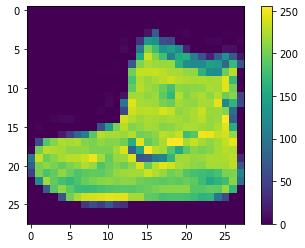

In [6]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [8]:
def custom_loss(y_true, y_pred, attention):
#     y_true, y_pred, attention = inputs[0], inputs[1], inputs[1]
    y_pred_att = tf.multiply(y_pred, attention)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred_att)
    return loss

def dummy_loss(y_true, y_pred):
    return y_pred

In [9]:
def loss_wrapper_fn(A):
    def loss_fn(y_true, y_pred):
        y_pred_att = tf.multiply(y_pred,A)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred_att)
        return loss
    return loss_fn #tf.keras.losses.sparse_categorical_crossentropy

In [10]:
input_shape = (28, 28)

inp = keras.layers.Input(shape=input_shape)
flat = keras.layers.Flatten(input_shape=(28, 28))(inp)
dense = keras.layers.Dense(128, activation='relu')(flat)
preds = keras.layers.Dense(10, activation='softmax')(dense)

att_layer = keras.layers.Dense(10, activation='softmax')
att = att_layer(flat)

labels = tf.keras.layers.Input(shape=(1,)) 

model=keras.models.Model(inputs=[inp, labels], outputs=[preds, att])


# preds_att = tf.multiply(preds, att)
# loss = tf.keras.losses.sparse_categorical_crossentropy(labels, preds_att)

loss = custom_loss(labels, preds, att)
model.add_loss(loss)
acc = tf.keras.metrics.sparse_categorical_accuracy(labels, preds)
model.add_metric(acc, name='acc', aggregation='mean')

# loss_layer = tf.keras.layers.Lambda(custom_loss)([labels, preds, att])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
model.compile(optimizer='adam',
#               metrics=[tf.keras.metrics.sparse_categorical_accuracy]
             )

In [12]:
model.fit(x=[train_images, train_labels], epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples
60000/60000 [==============================] - 2s 40us/sample - loss: 0.4960 - acc: 0.7887


In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
att_layer.get_weights()

In [ ]:
att_layer.get_weights()

In [99]:
def counter():
    c = 0
    while True:
        c += 1
        yield c
count = counter()

def zeros(shape, dtype=tf.bool):
    name = 'zeros_{}'.format(next(count))
    return tf.zeros(shape, dtype, name)

In [15]:
W = tf.constant([[0,0,1,0],
                 [0,0,0,1],
                 [1,0,0,0],
                 [0,1,0,0]], dtype=tf.float32)
I = tf.ones([4,4], dtype=tf.float32)
A = tf.constant([[1,1,0,0],
                 [1,1,0,0],
                 [0,0,1,1],
                 [0,0,1,1]], dtype=tf.float32)

In [16]:
tf.norm(tf.multiply(I-W, A))

<tf.Tensor: id=44, shape=(), dtype=float32, numpy=2.828427>

## Attention v2

In [581]:
y = tf.constant([[True, False], [False, True],
                 [False, True], [True, False]])

x = tf.constant([[1,2,3],[4,5,6],
                 [3,2,1],[4,4,4]], dtype=tf.float32)
C = 2
N = 4
D = 3
y, x

(<tf.Tensor: id=20093, shape=(4, 2), dtype=bool, numpy=
 array([[ True, False],
        [False,  True],
        [False,  True],
        [ True, False]])>,
 <tf.Tensor: id=20094, shape=(4, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [4., 5., 6.],
        [3., 2., 1.],
        [4., 4., 4.]], dtype=float32)>)

In [241]:
yTe = tf.broadcast_to(tf.expand_dims(y, axis=1), shape=(N, N, C))
eTy = tf.broadcast_to(tf.expand_dims(y, axis=0), shape=(N, N, C))
yTe, eTy

(<tf.Tensor: id=1733, shape=(4, 4, 2), dtype=bool, numpy=
 array([[[ True, False],
         [ True, False],
         [ True, False],
         [ True, False]],
 
        [[False,  True],
         [False,  True],
         [False,  True],
         [False,  True]],
 
        [[False,  True],
         [False,  True],
         [False,  True],
         [False,  True]],
 
        [[False,  True],
         [False,  True],
         [False,  True],
         [False,  True]]])>,
 <tf.Tensor: id=1737, shape=(4, 4, 2), dtype=bool, numpy=
 array([[[ True, False],
         [False,  True],
         [False,  True],
         [False,  True]],
 
        [[ True, False],
         [False,  True],
         [False,  True],
         [False,  True]],
 
        [[ True, False],
         [False,  True],
         [False,  True],
         [False,  True]],
 
        [[ True, False],
         [False,  True],
         [False,  True],
         [False,  True]]])>)

In [89]:
W = tf.cast(tf.logical_and(yTe, eTy),dtype=tf.bool)
W

<tf.Tensor: id=239, shape=(4, 4, 2), dtype=bool, numpy=
array([[[ True, False],
        [False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False,  True],
        [False,  True],
        [False,  True]],

       [[False, False],
        [False,  True],
        [False,  True],
        [False,  True]],

       [[False, False],
        [False,  True],
        [False,  True],
        [False,  True]]])>

In [90]:
tile_size = [N//2,N//2,C]
O = tf.zeros(tile_size, dtype=tf.bool)
I = tf.ones(tile_size, dtype=tf.bool)
mask = tf.concat([tf.concat([O, I], axis=0),
                  tf.concat([I, O], axis=0)], axis=1 )
mask

<tf.Tensor: id=255, shape=(4, 4, 2), dtype=bool, numpy=
array([[[False, False],
        [False, False],
        [ True,  True],
        [ True,  True]],

       [[False, False],
        [False, False],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [False, False],
        [False, False]],

       [[ True,  True],
        [ True,  True],
        [False, False],
        [False, False]]])>

In [91]:
W_mask = tf.logical_and(W,mask)

In [104]:
W = tf.cast(W, dtype=tf.float32)
W_mask = tf.cast(W_mask, dtype=tf.float32)

In [105]:
tf.reduce_sum(W, axis=2), tf.reduce_sum(W_mask, axis=2)

(<tf.Tensor: id=301, shape=(4, 4), dtype=float32, numpy=
 array([[1., 0., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.]], dtype=float32)>,
 <tf.Tensor: id=303, shape=(4, 4), dtype=float32, numpy=
 array([[0., 0., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=float32)>)

In [346]:
B = tf.constant(np.arange(0, D*D*C, dtype=np.float32), shape=[C,D,D])
bias = tf.constant(np.arange(0, C*D, dtype=np.float32), shape=[C,D])

In [335]:
xTe = tf.broadcast_to(tf.expand_dims(x, axis=0), shape=(C, N, D))
xTe

<tf.Tensor: id=2682, shape=(2, 4, 3), dtype=float32, numpy=
array([[[1., 2., 3.],
        [4., 5., 6.],
        [3., 2., 1.],
        [4., 4., 4.]],

       [[1., 2., 3.],
        [4., 5., 6.],
        [3., 2., 1.],
        [4., 4., 4.]]], dtype=float32)>

In [229]:
xTe.shape, W_mask.shape

(TensorShape([Dimension(2), Dimension(4), Dimension(3)]),
 TensorShape([Dimension(4), Dimension(4), Dimension(2)]))

In [349]:
b = tf.broadcast_to(tf.expand_dims(bias, axis=1), shape=(C, N, D))
xB = tf.matmul(xTe, B) + b
xBBx = tf.matmul(xB, xB, transpose_b=True)
# xBx = tf.matmul(tf.matmul(xTe, B), xTe, transpose_b=True)
# xBx = tf.transpose(xBx, perm=[1,2,0])
# xBx
xB, xBBx

(<tf.Tensor: id=2744, shape=(2, 4, 3), dtype=float32, numpy=
 array([[[ 24.,  31.,  38.],
         [ 51.,  67.,  83.],
         [ 12.,  19.,  26.],
         [ 36.,  49.,  62.]],
 
        [[ 81.,  88.,  95.],
         [189., 205., 221.],
         [ 69.,  76.,  83.],
         [147., 160., 173.]]], dtype=float32)>,
 <tf.Tensor: id=2745, shape=(2, 4, 4), dtype=float32, numpy=
 array([[[  2981.,   6455.,   1865.,   4739.],
         [  6455.,  13979.,   4043.,  10265.],
         [  1865.,   4043.,   1181.,   2975.],
         [  4739.,  10265.,   2975.,   7541.]],
 
        [[ 23330.,  54344.,  20162.,  42422.],
         [ 54344., 126587.,  46964.,  98816.],
         [ 20162.,  46964.,  17426.,  36662.],
         [ 42422.,  98816.,  36662.,  77138.]]], dtype=float32)>)

In [306]:
def broadcast_x(x, C):
    N = x.shape[0]
    D = x.shape[1]

    xTe = tf.broadcast_to(tf.expand_dims(x, axis=0), shape=(C, N, D))
    return xTe

In [416]:
def get_attention(x, y, B):
    N = y.shape[0]
    C = y.shape[1]
    D = x.shape[1]
    
    # create W
    yTe = tf.broadcast_to(tf.expand_dims(y, axis=1), shape=(N, N, C))
    eTy = tf.broadcast_to(tf.expand_dims(y, axis=0), shape=(N, N, C))
    W_full = tf.logical_and(yTe, eTy)

    # create W_st (source-target)
    tile_size = [N//2,N//2,C]
    O = tf.zeros(tile_size, dtype=tf.bool)
    I = tf.ones(tile_size, dtype=tf.bool)
    mask = tf.concat([tf.concat([O, I], axis=0),
                      tf.concat([I, O], axis=0)], axis=1 )
    W_st = tf.logical_and(W_full, mask)

    # create xBBx
    bias = tf.constant(np.arange(0, (C*D).value, dtype=np.float32), shape=[C,D])
    b = tf.broadcast_to(tf.expand_dims(bias, axis=1), shape=(C, N, D))
    xB = tf.matmul(xTe, B) + b
    xBBx = tf.matmul(xB, xB, transpose_b=True)
    xBBx = tf.transpose(xBBx, perm=[1,2,0])

    # mask using W
    A_C = tf.where(W_st, xBx, tf.zeros_like(xBx))
    A = tf.reduce_sum(A_C, axis=2)
    return A

D, C = 3, 2
B = tf.constant(np.arange(0, (D*D*C), dtype=np.float32), shape=[C,D,D])

get_attention(x,y,B)

<tf.Tensor: id=3978, shape=(4, 4), dtype=float32, numpy=
array([[   0.,    0.,    0.,    0.],
       [   0.,    0., 1176., 2412.],
       [   0., 1092.,    0.,    0.],
       [   0., 2364.,    0.,    0.]], dtype=float32)>

In [304]:
attention_layer = tf.keras.layers.Lambda(lambda z: get_attention(z[0],z[1], z[2]))
attention_layer([x, y, B])

<tf.Tensor: id=2587, shape=(4, 4), dtype=float32, numpy=
array([[    0.,     0.,     0.,     0.],
       [    0.,     0., 43596., 94428.],
       [    0., 43596.,     0.,     0.],
       [    0., 94428.,     0.,     0.]], dtype=float32)>

In [313]:
C, D = 2,3
def broadcast_x(x, C):
    N = x.shape[0]
    D = x.shape[1]
    xTe = tf.broadcast_to(tf.expand_dims(x, axis=0), shape=(C, N, D))
    return xTe

broadcast_layer = keras.layers.Lambda(lambda x: broadcast_x(x, C))
B_layer = keras.layers.Dense(D, activation=None, kernel_initializer='glorot_uniform', bias_initializer='zeros', name='att_B')

xTe = broadcast_layer(x)
xTe, B_layer(xTe)

(<tf.Tensor: id=2639, shape=(2, 4, 3), dtype=float32, numpy=
 array([[[1., 2., 3.],
         [4., 5., 6.],
         [3., 2., 1.],
         [4., 4., 4.]],
 
        [[1., 2., 3.],
         [4., 5., 6.],
         [3., 2., 1.],
         [4., 4., 4.]]], dtype=float32)>,
 <tf.Tensor: id=2675, shape=(2, 4, 3), dtype=float32, numpy=
 array([[[-1.9459436 , -1.4866495 ,  0.64783645],
         [-4.4430037 , -4.626745  ,  0.27498078],
         [-1.3834698 , -2.7001448 , -1.1449773 ],
         [-3.3294134 , -4.1867943 , -0.49714088]],
 
        [[-1.9459436 , -1.4866495 ,  0.64783645],
         [-4.4430037 , -4.626745  ,  0.27498078],
         [-1.3834698 , -2.7001448 , -1.1449773 ],
         [-3.3294134 , -4.1867943 , -0.49714088]]], dtype=float32)>)

In [312]:
B_layer.weights

[<tf.Variable 'att_B/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.40792704,  0.01533341,  0.9023566 ],
        [ 0.16194725,  0.4354167 ,  0.43807793],
        [-0.9853258 ,  0.10133934,  0.68444157]], dtype=float32)>,
 <tf.Variable 'att_B/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [598]:
from tensorflow.python.keras import activations
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.framework import dtypes
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Layer

class DenseAttention(Layer):

    def __init__(self,
                 classes,
                 omit_intra_domain=True,
                 activation='softmax',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super(DenseAttention, self).__init__(activity_regularizer=regularizers.get(activity_regularizer), **kwargs)
        self.classes = int(classes)
        self.omit_intra_domain = omit_intra_domain
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.supports_masking = True
        self.input_spec = InputSpec(min_ndim=2)

    def build(self, input_shape):
        dtype = dtypes.as_dtype(self.dtype or K.floatx())
        if not (dtype.is_floating or dtype.is_complex):
            raise TypeError('Unable to build `Dense` layer with non-floating point dtype %s' % (dtype,))
        input_shape = tensor_shape.TensorShape(input_shape) # N x D
        self.dims = tensor_shape.dimension_value(input_shape[-1])
        if self.dims is None:
            raise ValueError('The last dimension of the inputs to `DenseAttention` should be defined. Found `None`.')
        
        self.input_spec = InputSpec(min_ndim=2, axes={ -1: self.dims})
        weight_shape = [self.classes, self.dims, self.dims] # C x D x D
        bias_shape = [self.classes, self.dims] # C x D
        
        self.kernel = self.add_weight(
            'kernel',
            shape=weight_shape,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            dtype=self.dtype,
            trainable=True
        )
        if self.use_bias:
            self.bias = self.add_weight(
                'bias',
                shape=bias_shape,
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                dtype=self.dtype,
                trainable=True
            )
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, labels):
        rank = len(inputs.shape)
        if rank != 2:
            raise ValueError('The input to `DenseAttention` should be of rank 2, but got input of shape %s'% input_shape)
        if K.is_sparse(inputs):
            raise ValueError("`DenseAttention` doesn't support SparseTensor as input")
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, self.kernel)
            
        inputs = math_ops.cast(inputs, self._compute_dtype)
        num_samples = tensor_shape.dimension_value(inputs.shape[0])
        
        # broadcast input to the number of classes
        inputs_shape_b = [self.classes, num_samples, self.dims]
        xTe = tf.broadcast_to(tf.expand_dims(inputs, axis=0), shape=inputs_shape_b)
        
        # apply attention-weights
        xB = tf.matmul(xTe, self.kernel)
        if self.use_bias:
            bias = tf.broadcast_to(tf.expand_dims(self.bias, axis=1), shape=inputs_shape_b)
            xB = tf.add(xB, bias)
        xBBx = tf.matmul(xB, xB, transpose_b=True)
        xBBx = tf.transpose(xBBx, perm=[1,2,0])
        
        # create masking according to samples classes
        labels_shape_b = [num_samples, num_samples, self.classes ]
        yTe = tf.broadcast_to(tf.expand_dims(labels, axis=1), shape=labels_shape_b)
        eTy = tf.broadcast_to(tf.expand_dims(labels, axis=0), shape=labels_shape_b)
        W = tf.equal(yTe, eTy)

        if self.omit_intra_domain:
            tile_size = [num_samples//2, num_samples//2, self.classes]
            zeros = tf.zeros(tile_size, dtype=tf.bool)
            ones = tf.ones(tile_size, dtype=tf.bool)
            mask = tf.concat([tf.concat([zeros, ones], axis=0),
                              tf.concat([ones, zeros], axis=0)], axis=1 )
            W = tf.logical_and(W, mask)

        A = tf.where(W, xBBx, tf.zeros_like(xBBx)) # mask using W
        
        if self.activation is not None:
            A = tf.reshape(A,[C, num_samples*num_samples])
            A = self.activation(A) # pylint: disable=not-callable
            A = tf.reshape(A,[num_samples,num_samples, C])
            A = tf.where(W, A, tf.zeros_like(A)) # mask again to remove spill-over from softmax
            
        outputs = tf.reduce_sum(A, axis=2) #reduce along the channel axis
        return outputs

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        if tensor_shape.dimension_value(input_shape[-1]) is None:
            raise ValueError('The innermost dimension of input_shape must be defined, but saw: %s'% input_shape)
        return [input_shape[0], input_shape[0]]

    def get_config(self):
        config = {
            'classes': self.classes,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(DenseAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [599]:
x, y

(<tf.Tensor: id=20094, shape=(4, 3), dtype=float32, numpy=
 array([[1., 2., 3.],
        [4., 5., 6.],
        [3., 2., 1.],
        [4., 4., 4.]], dtype=float32)>,
 <tf.Tensor: id=20093, shape=(4, 2), dtype=bool, numpy=
 array([[ True, False],
        [False,  True],
        [False,  True],
        [ True, False]])>)

In [600]:
attention_layer = DenseAttention(classes=y.shape[1], use_bias=True, activation=None)
attention_layer_th = DenseAttention(classes=y.shape[1], use_bias=True, activation='tanh')
attention_layer_sm = DenseAttention(classes=y.shape[1], use_bias=True, activation='softmax')
attention_layer(x,y), attention_layer_th(x,y), attention_layer_sm(x,y)

(<tf.Tensor: id=21308, shape=(4, 4), dtype=float32, numpy=
 array([[ 0.      ,  0.      ,  0.      , 32.96839 ],
        [ 0.      ,  0.      , 34.157997,  0.      ],
        [ 0.      , 34.157997,  0.      ,  0.      ],
        [32.96839 ,  0.      ,  0.      ,  0.      ]], dtype=float32)>,
 <tf.Tensor: id=21382, shape=(4, 4), dtype=float32, numpy=
 array([[0.       , 0.       , 0.       , 1.9827853],
        [0.       , 0.       , 1.9999979, 0.       ],
        [0.       , 1.9999979, 0.       , 0.       ],
        [1.9827853, 0.       , 0.       , 0.       ]], dtype=float32)>,
 <tf.Tensor: id=21456, shape=(4, 4), dtype=float32, numpy=
 array([[0.        , 0.        , 0.        , 0.87377375],
        [0.        , 0.        , 0.12622614, 0.        ],
        [0.        , 0.12622614, 0.        , 0.        ],
        [0.87377375, 0.        , 0.        , 0.        ]], dtype=float32)>)

In [519]:
o = attention_layer(x,y)
print(o)
o = tf.reshape(o,[1,N*N])
o = 2*activations.get('softmax')(o)
o = tf.reshape(o,[N,N])
print(o)

tf.Tensor(
[[ 0.        0.        0.        0.      ]
 [ 0.        0.       24.994654 57.475113]
 [ 0.       24.994654  0.        0.      ]
 [ 0.       57.475113  0.        0.      ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[1.0936431e-25 1.0936431e-25 1.0936431e-25 1.0936431e-25]
 [1.0936431e-25 1.0936431e-25 7.8327627e-15 1.0000000e+00]
 [1.0936431e-25 7.8327627e-15 1.0936431e-25 1.0936431e-25]
 [1.0936431e-25 1.0000000e+00 1.0936431e-25 1.0936431e-25]], shape=(4, 4), dtype=float32)


In [523]:
tf.reduce_sum(o, axis=0)

<tf.Tensor: id=9107, shape=(4,), dtype=float32, numpy=
array([4.3745724e-25, 1.0000000e+00, 7.8327627e-15, 1.0000000e+00],
      dtype=float32)>